In [52]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta

from math import log, sqrt, pi, exp
from scipy.stats import norm
#from pandas import DataFrame
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yfin
yfin.pdr_override()

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
plt.rcParams["figure.figsize"] = (10,6)
import warnings

# Assignment

- Select an asset in your portfolio and identify a closely correlated asset. 

- Prepare a Candlestick chart for the past year that demonstrates the correlation of the asset in your portfolio and the closely correlated asset.


# Setup
## Variables

In [53]:
# Portfolio Sub Class U.S. Equities
ticker = ['ARKK',
         'EXAS',
         'FSMD',
         'IMCB',
         'IVV',
         'NVTA',
         'PATH',
         'SCHD',
         'TWLO',
         'VBR',
         'VO',
         'VONG',
         'SPY']


# pairs to trade
sp_list = ['IVV','TWLO']


today = datetime.today()
offset = max(1, (today.weekday() + 6) % 7 - 3)
timed = timedelta(offset)
today_business = today - timed
print("d1 =", today_business)

today = today_business.strftime("%Y-%m-%d")
start = '2022-01-01' 
end = today


d1 = 2023-10-20 15:20:05.475845


## Functions

In [54]:


def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
        
        
        
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs



# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money


# Load Data

In [55]:
df = pdr.get_data_yahoo(ticker, start=start, end=today)['Close']
df.dropna(inplace=True, axis=1) 
df1 = pdr.get_data_yahoo(sp_list[0], start=start, end=today)
df2 = pdr.get_data_yahoo(sp_list[1], start=start, end=today)

[*********************100%%**********************]  13 of 13 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# 1.0 Asset Selection
The Pairs Trading Strategy is applied to the U.S Equity portion of the portfolio. The first step is identifying paired assets to pair trade. I have included SPY in the list of assets for comparison purposes. 

## 1.1 Correlation
The correlation headmap identifies several options for the pairs trading strategy including:

- IVV and SPY
- VO and IMCB

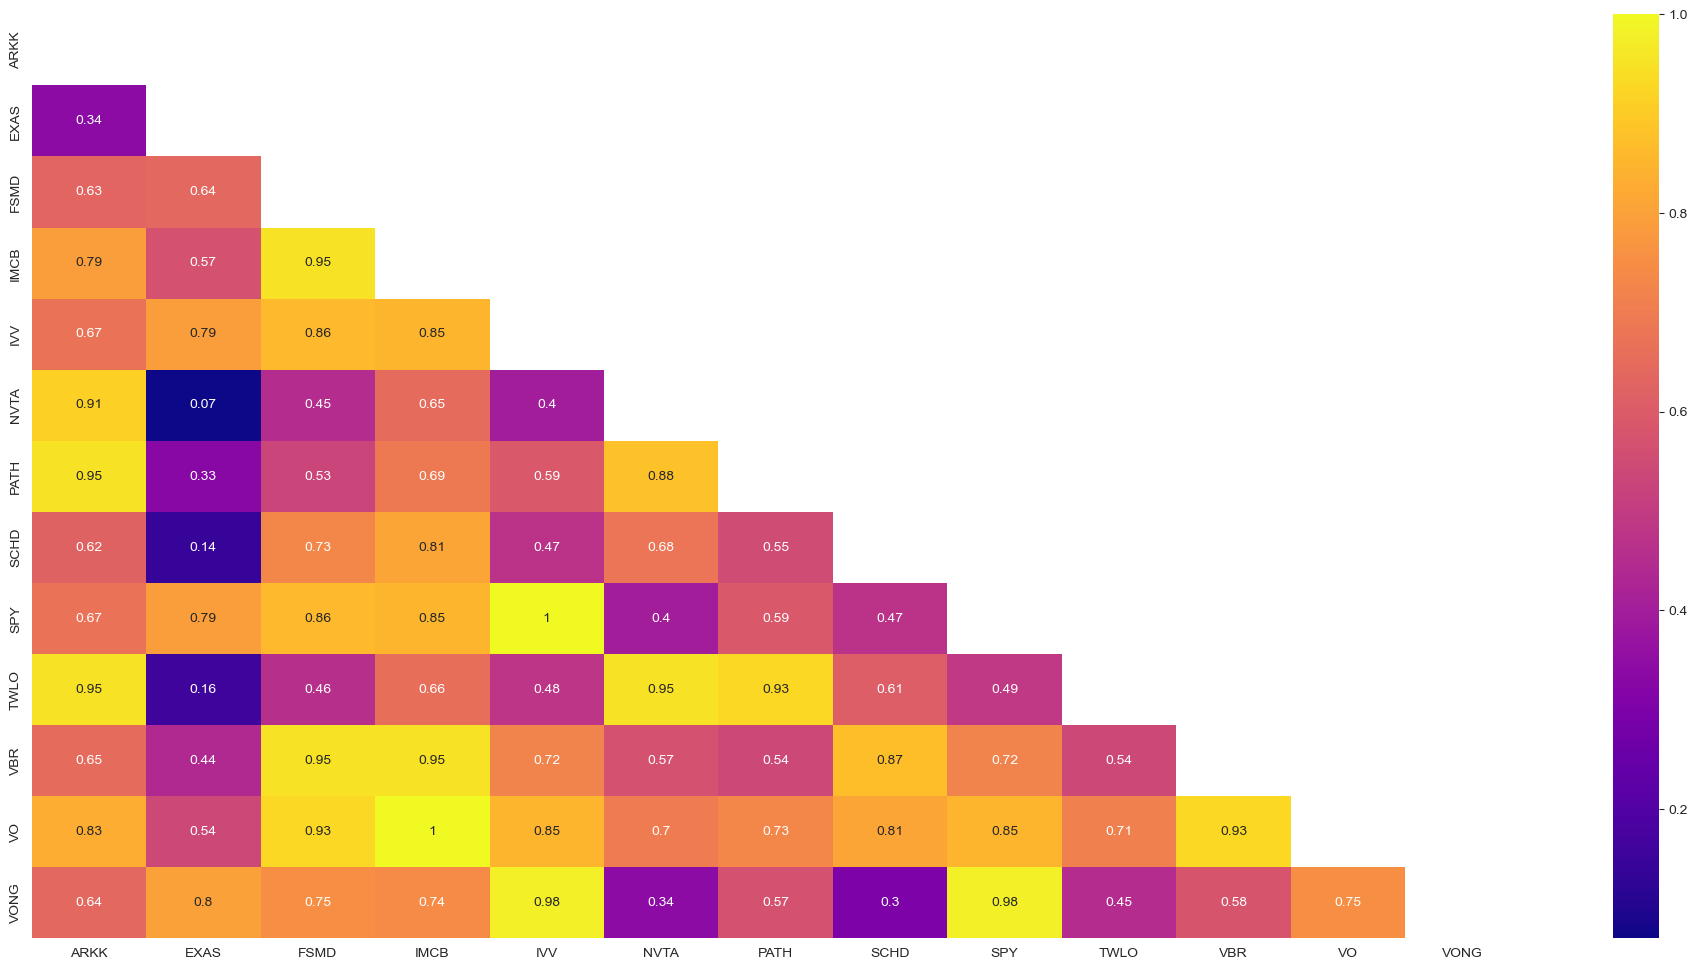

In [56]:
plt.figure(figsize=(24,12))
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 10})

## 1.2 Cointegration
An alternative statistical measure to correlation is cointegration. Cointegration is a technique used to find a possible correlation between time series processes in the long term. The cointegration model identifies different pairs including

- IVV and TWLO
- ARKK and FSMD

In [57]:
scores, pvalues, pairs = find_cointegrated_pairs(df)

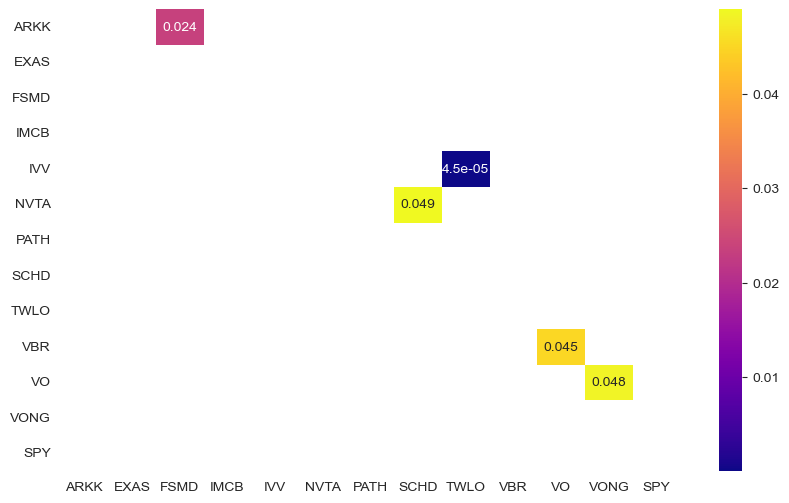

In [58]:
_p = sns.heatmap(pvalues, xticklabels=ticker, yticklabels=ticker, cmap='plasma', 
                annot_kws={"size": 10}, annot=True,mask = (pvalues >= 0.05)
                )

# 2. Pairs Trade (IVV and SPY) 
## 2.1 Load Data

In [59]:
# pairs to trade
sp_list = ['IVV','SPY']

In [60]:
df1 = pdr.get_data_yahoo(sp_list[0], start=start, end=today)
df2 = pdr.get_data_yahoo(sp_list[1], start=start, end=today)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## 2.2 Candle Stick Graph

In [61]:
trace1 = {
    'x': df1.index,
    'open': df1.Open,
    'close': df1.Close,
    'high': df1.High,
    'low': df1.Low,
    'type': 'candlestick',
    'name': sp_list[0],
    'showlegend': True
}

In [62]:
trace2 = {
    'x': df2.index,
    'open': df2.Open,
    'close': df2.Close,
    'high': df2.High,
    'low': df2.Low,
    'type': 'candlestick',
    'name': sp_list[1],
    'showlegend': True
}

In [63]:
data = [trace1, trace2]

# Config graph layout
layout = go.Layout({
    'title': {
        'text': 'Moving Averages',
        'font': {
            'size': 15
        }
    }
})

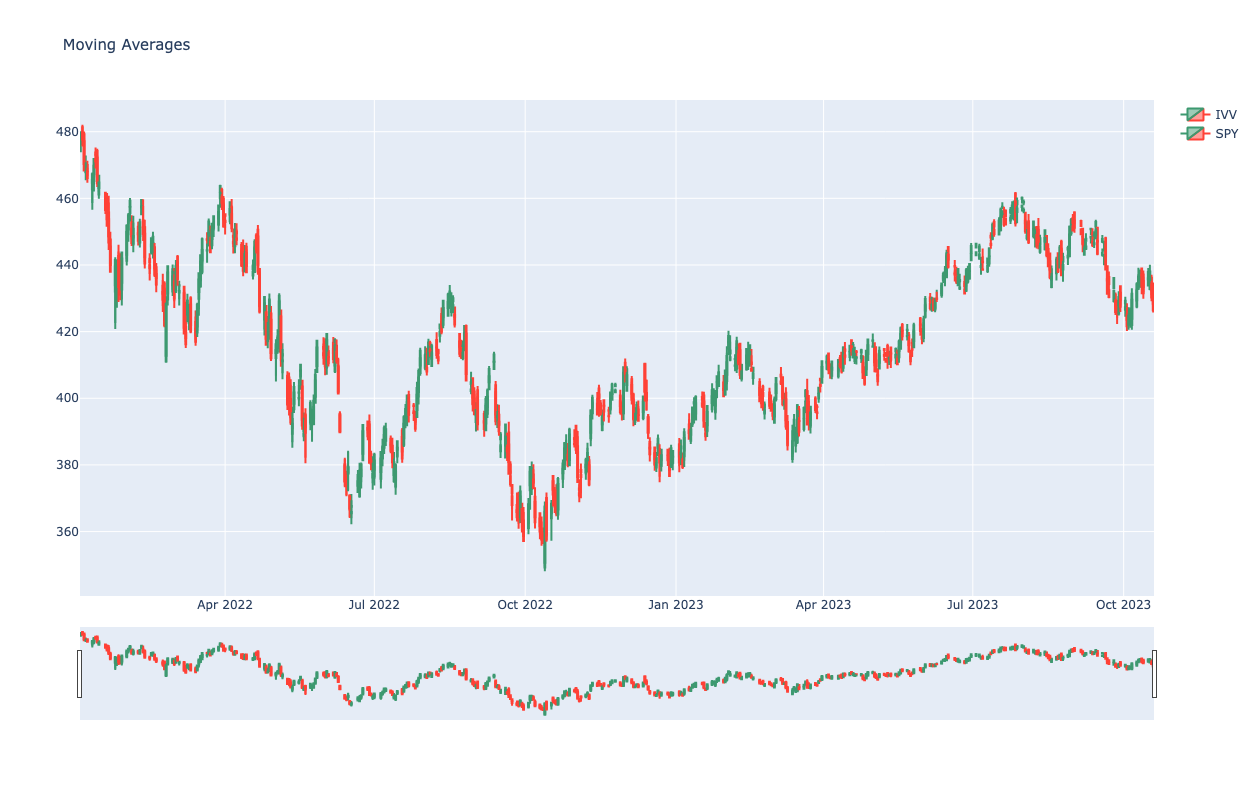

In [64]:
fig = go.Figure(data=data, layout=layout)
fig.update_layout(width=1200, height=800)
fig.show()

In [65]:
S1 = df1.Close
S2 = df2.Close

ratio = S1/S2

score, pvalue, _ = coint(S1, S2)
print('coint (IVV & SPY): ' , pvalue)

coint (IVV & SPY):  4.4886773206378065e-05


## 2.3 Spread
Plot the spread of two time series using linear regression to get the coefficient.

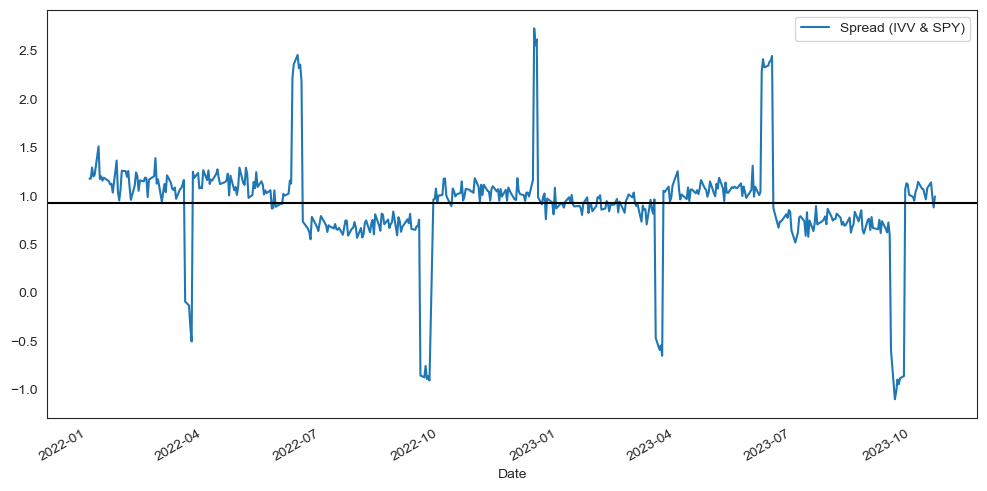

In [66]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = df1.Close
b = results.params['Close']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')

plt.legend(['Spread (IVV & SPY)']);

In [67]:
#Calculate Price Ratio
ratios = df1.Close / df2.Close
l = int((len(ratios) * .7))
print('train index: ', l) 

# Train Test Split
train = ratios[:l]
test = ratios[l:]

# Assign Buy and Sell
buy = train.copy()
sell = train.copy()

train index:  316


## 2.4 Trading Signals
Calculate the trading signals for the stock based on the direction of price movement.

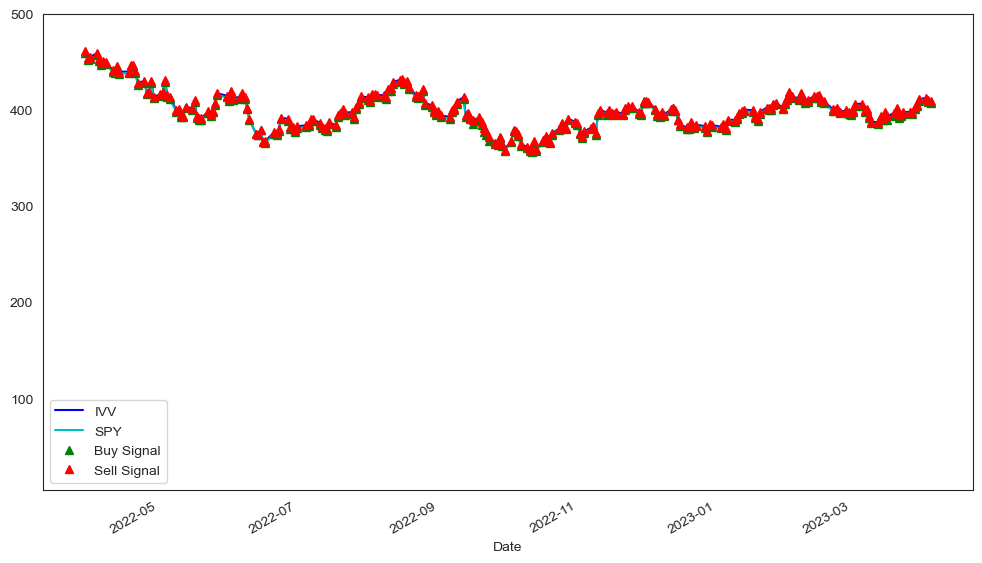

In [68]:
plt.figure(figsize=(12,7))
S1 = df1['Close'].iloc[:l]
S2 = df2['Close'].iloc[:l]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(5, 500)
#plt.xlim('2013-03-22', '2016-07-04')

plt.legend(['IVV', 'SPY', 'Buy Signal', 'Sell Signal'])
plt.show()

## 2.5 Backtesting Pairs Trade Strategy

In [69]:
profit_var = trade(df1.Close.iloc[l:], df2.Close.iloc[l:], 60, 5)
print('Backtested Profit', round(profit_var,2))

Backtested Profit -54.57


# 3. Pairs Trade (IVV and TWLO)
## 3.1 Load Data

In [70]:
# pairs to trade
sp_list = ['IVV','TWLO']



In [71]:
df1 = pdr.get_data_yahoo(sp_list[0], start=start, end=today)
df2 = pdr.get_data_yahoo(sp_list[1], start=start, end=today)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## 3.2 Candle Stick Graph

In [72]:
trace1 = {
    'x': df1.index,
    'open': df1.Open,
    'close': df1.Close,
    'high': df1.High,
    'low': df1.Low,
    'type': 'candlestick',
    'name': sp_list[0],
    'showlegend': True
}

In [73]:
trace2 = {
    'x': df2.index,
    'open': df2.Open,
    'close': df2.Close,
    'high': df2.High,
    'low': df2.Low,
    'type': 'candlestick',
    'name': sp_list[1],
    'showlegend': True
}

In [74]:
data = [trace1, trace2]

# Config graph layout
layout = go.Layout({
    'title': {
        'text': 'Moving Averages',
        'font': {
            'size': 15
        }
    }
})

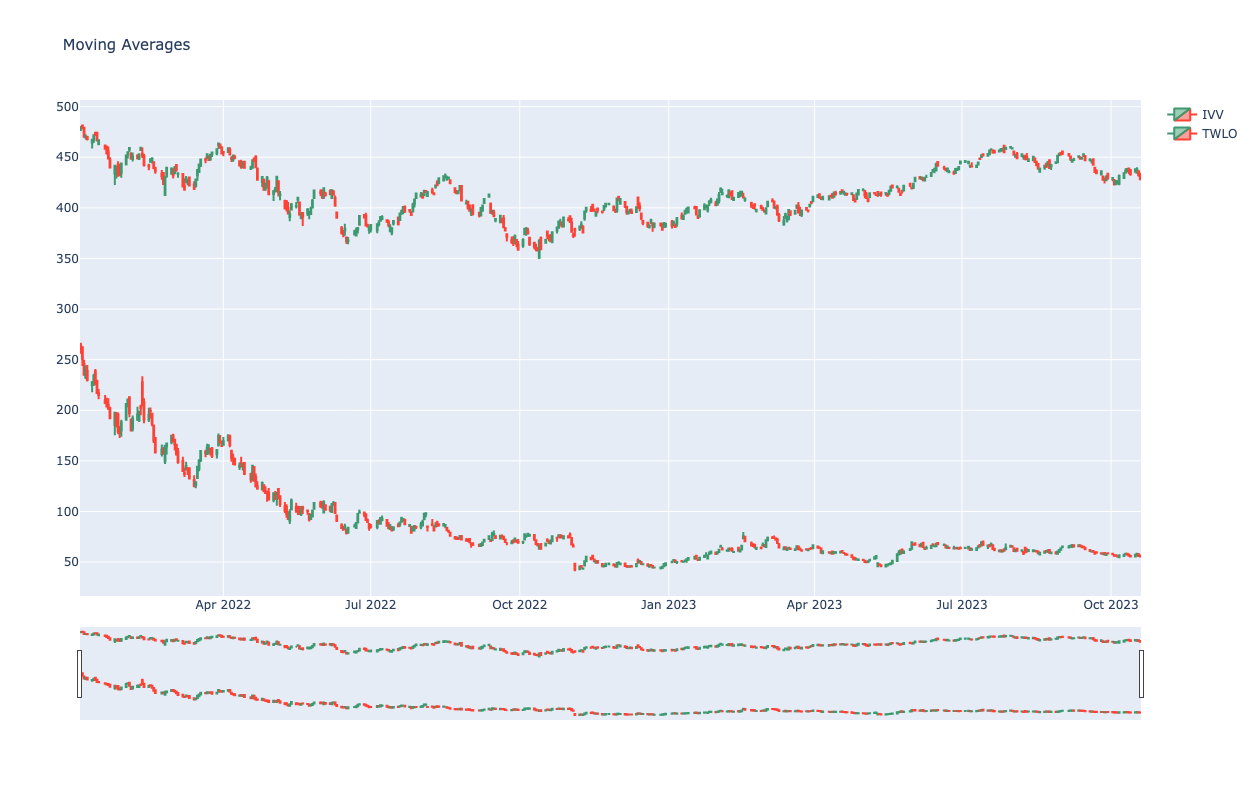

In [75]:
fig = go.Figure(data=data, layout=layout)
fig.update_layout(width=1200, height=800)
fig.show()

In [76]:
S1 = df1.Close
S2 = df2.Close

ratio = S1/S2

score, pvalue, _ = coint(S1, S2)
print('coint (IVV & SPY): ' , pvalue)

coint (IVV & SPY):  0.4968857004192825


## 3.3 Spread
Plot the spread of two time series using linear regression to get the coefficient.

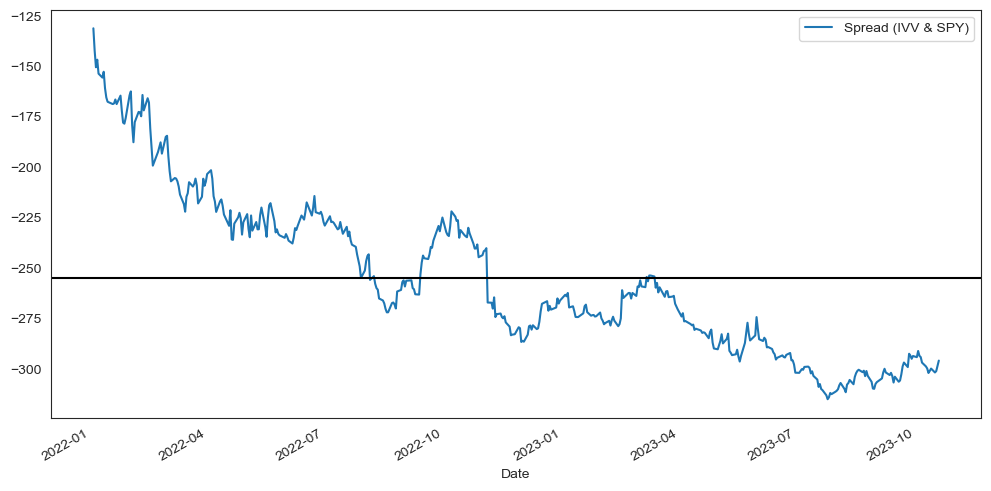

In [77]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = df1.Close
b = results.params['Close']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')

plt.legend(['Spread (IVV & SPY)']);

In [78]:
#Calculate Price Ratio
ratios = df1.Close / df2.Close
l = int((len(ratios) * .7))
print('train index: ', l) 

# Train Test Split
train = ratios[:l]
test = ratios[l:]

# Assign Buy and Sell
buy = train.copy()
sell = train.copy()

train index:  316


## 3.4 Trading Signals
Calculate the trading signals for the stock based on the direction of price movement.

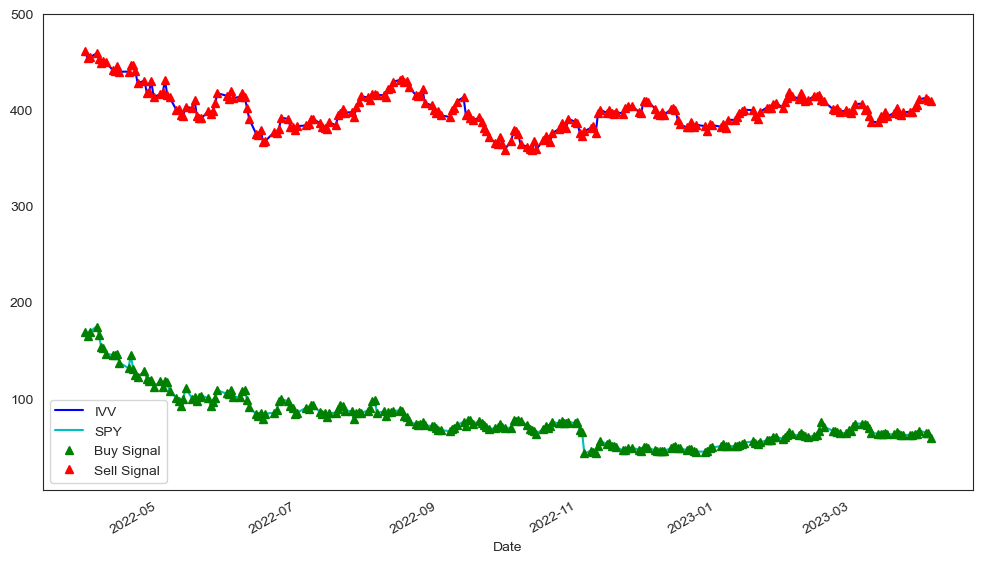

In [79]:
plt.figure(figsize=(12,7))
S1 = df1['Close'].iloc[:l]
S2 = df2['Close'].iloc[:l]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(5, 500)
#plt.xlim('2013-03-22', '2016-07-04')

plt.legend(['IVV', 'SPY', 'Buy Signal', 'Sell Signal'])
plt.show()

## 3.5 Backtesting Pairs Trade Strategy

In [80]:
profit_var = trade(df1.Close.iloc[l:], df2.Close.iloc[l:], 60, 5)
print('Backtested Profit', round(profit_var,2))

Backtested Profit 1340.81


# Conclusion
The IVV and TWLO pairs trading strategy generates 1340.81 in profits when we backtest the portfolio.